### Генерация лиц с использованием GAN

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch

print("Current GPU:", torch.cuda.current_device())
print("Available GPUs:", torch.cuda.device_count())

Current GPU: 0
Available GPUs: 1


In [4]:
from yfile import download_from_yadisk
import os

TARGET_DIR = '.'
FILENAME = "celeba.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
    download_from_yadisk(
        short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
        filename=FILENAME,
        target_dir=TARGET_DIR
    )

In [ ]:
!unzip celeba.zip

In [6]:
#!L
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

use_cuda = torch.cuda.is_available()
device = "cuda"
print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 2.4.1+cu121
Using GPU


### Подготовка датасета

In [7]:
class CropCelebA64:
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [8]:
train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

IMG_SHAPE = tuple(train_dataset[0][0].shape)

# Примеры изображений

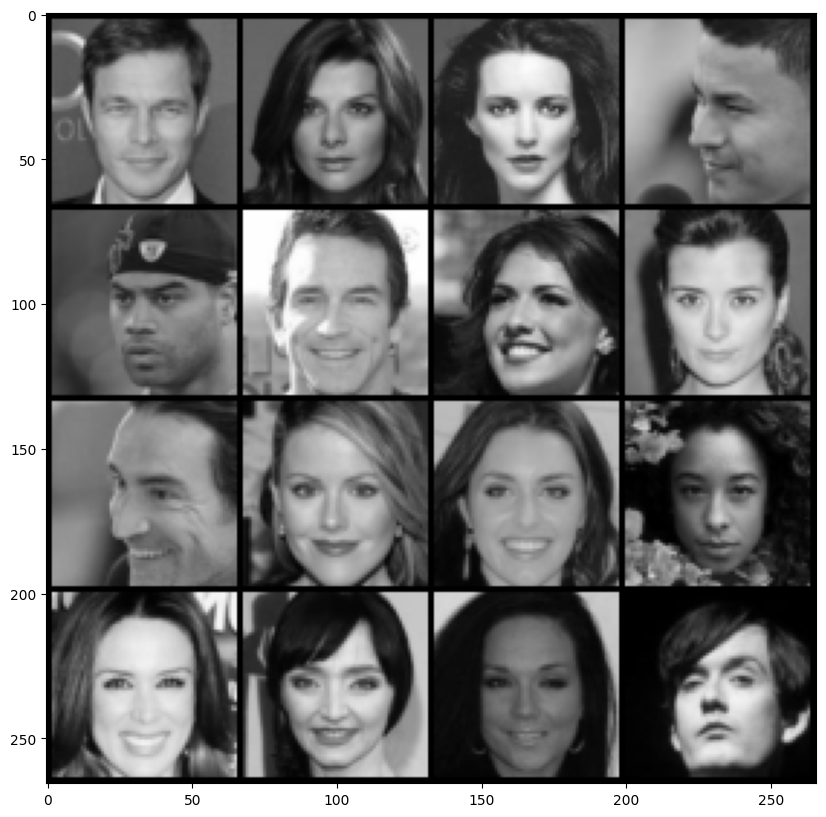

In [9]:
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

In [10]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.to(device) if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape
    
    def forward(self,input):
        return input.view(self.shape)

# Архитектура генератора

In [11]:
CODE_SIZE = 128

generator = nn.Sequential()

generator.add_module('linear1', nn.Linear(CODE_SIZE, 10*8*8))
generator.add_module('act1', nn.ELU())
generator.add_module('reshape1', Reshape([-1, 10, 8, 8]))

generator.add_module('conv2', nn.ConvTranspose2d(10, 64, kernel_size=(3,3), padding=1))
generator.add_module('act2', nn.ELU())
generator.add_module('upsample1', nn.Upsample(scale_factor=2))

generator.add_module('conv3', nn.ConvTranspose2d(64, 32, kernel_size=(3,3), padding=1))
generator.add_module('act3', nn.ELU())
generator.add_module('upsample3', nn.Upsample(scale_factor=2))

generator.add_module('conv4', nn.ConvTranspose2d(32, 8, kernel_size=(3,3), padding=1))
generator.add_module('act4', nn.ELU())
generator.add_module('upsample4', nn.Upsample(scale_factor=2))

generator.add_module('conv5', nn.ConvTranspose2d(8, 1, kernel_size=(3,3), padding=1))
generator.add_module('act_last4', nn.Sigmoid())

generator = generator.to(device)

In [12]:
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE, tuple(generated_data.shape)[1:])

### Архитектура дискриминатора

In [13]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.stack([train_dataset[idx][0] for idx in idxs], dim=0)
    return batch.to(device) if use_cuda else batch.cpu()

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [14]:
discriminator = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(3, 3), padding=1),
    nn.ELU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(8, 32, kernel_size=(3, 3), padding=1),
    nn.ELU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
    nn.ELU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
    nn.ELU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
    nn.ELU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1),
    nn.ELU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(1, -1),
    nn.Linear(512, 1),
).to(device)

discriminator = discriminator.to(device)

In [15]:
discriminator(sample_data_batch(4))

tensor([[-0.0528],
        [-0.0537],
        [-0.0533],
        [-0.0537]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Вспомогательные функции для обучения

In [16]:
#!L
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    
    disc_on_generated_data = discriminator(generated_data)
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    
    loss = -torch.mean(logp_gen_is_real)
    
    return loss

In [17]:
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.7199, device='cuda:0', grad_fn=<NegBackward0>)


In [18]:
#!L
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(-disc_on_fake_data)
    
    loss = -torch.mean(logp_real_is_real + logp_gen_is_fake)
    return loss

In [19]:
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(1.3874, device='cuda:0', grad_fn=<NegBackward0>)


### Вспомогательные функции

In [39]:
def sample_images(nrow, ncol, sharp=False, *, save_filename=None):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(0, 1)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    if save_filename:
        plt.savefig(save_filename)
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = torch.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = torch.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training

In [26]:
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

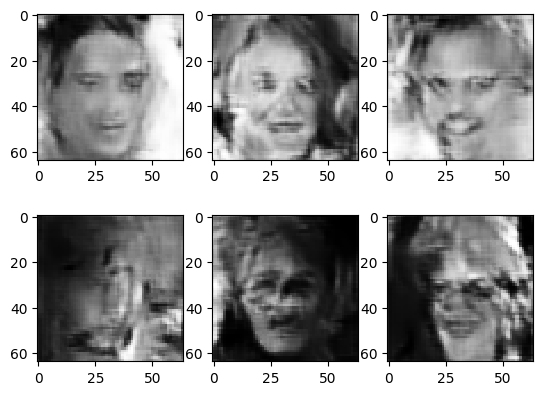

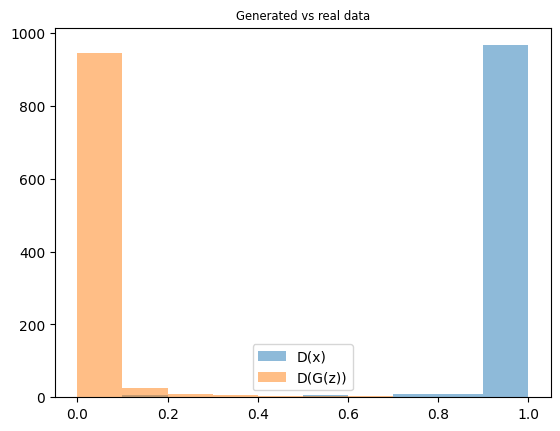

In [28]:
from IPython import display
from tqdm.auto import tqdm

batch_size = 100
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for epoch in range(1):
    for iteration, (batch, _) in tqdm(enumerate(loader)):

        real_data = batch.cuda()
        fake_data = generator(sample_noise_batch(batch_size))
        disc_loss = discriminator_loss(real_data, fake_data)
        gen_loss = discriminator_loss(real_data, fake_data)

        # print(disc_loss.item(), gen_loss.item())

        # if disc_loss.item() > 1000:
        #     disc_opt.zero_grad()
        #     disc_loss.backward()
        #     disc_opt.step()
        # if gen_loss.item() > 1000:
        #     gen_loss.zero_grad()
        #     gen_loss.backward()
        #     gen_opt.step()
            

        # Train discriminator
        real_data = batch.cuda() if use_cuda else batch.cpu()
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()

        # Train generator
        if iteration % 5 == 0:
            noise = sample_noise_batch(batch_size)
            loss = generator_loss(noise)
            gen_opt.zero_grad()
            loss.backward()
            gen_opt.step()

        if iteration % 100 == 0:
            print(epoch)
            # print(loss.item())
            display.clear_output(wait=True)
            sample_images(2,3,True)
            sample_probas(1000)
        

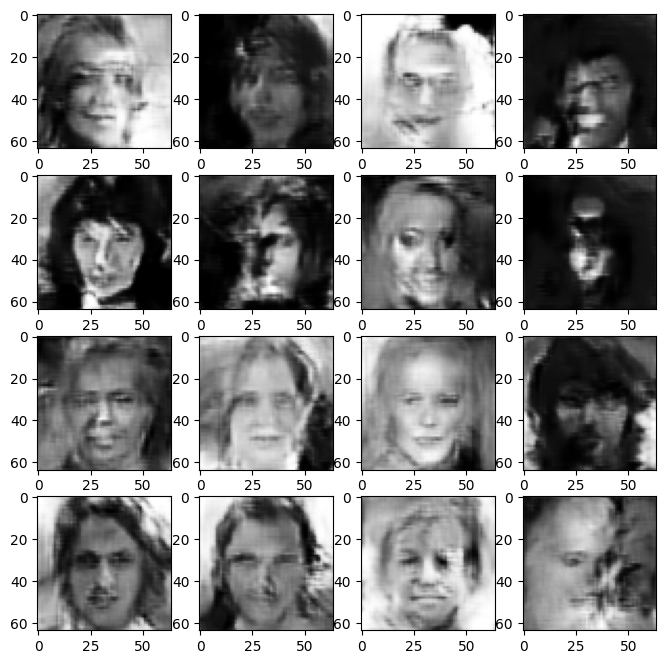

In [41]:
plt.figure(figsize=[8, 8])
sample_images(4, 4, save_filename='fig.png')